# YRoration (YGate) - hls4ml

## Configuration

Pulse and fidelity computation are computation intensive (slow).

In [1]:
PULSE_ENABLED = False
FIDELITY_ENABLED = True

Parameters are stored in a shared script.

In [2]:
from parameters import *

## Library

In [3]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import qkeras
#from tensorflow.keras.models import load_model

import sys
sys.path.append('..')

from utils.helpers import *
from utils.plotting import *

# Disable some console warnings
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

## Check GPU

## Dataset

### Load

In [4]:
x_train = np.load('./data/yrotation/{}/x_train.npy'.format(CSV_CONFIG))
x_val = np.load('./data/yrotation/{}/x_val.npy'.format(CSV_CONFIG))
x_test = np.load('./data/yrotation/{}/x_test.npy'.format(CSV_CONFIG))
y_train = np.load('./data/yrotation/{}/y_train.npy'.format(CSV_CONFIG))
y_val = np.load('./data/yrotation/{}/y_val.npy'.format(CSV_CONFIG))
y_test = np.load('./data/yrotation/{}/y_test.npy'.format(CSV_CONFIG))

In [5]:
N_ANGLES = x_train.shape[1]
N_PARAMS = y_train.shape[1]

In [6]:
print('---------------------------------------')
print('- Pulse parameters (y) #', N_PARAMS) # ASSUMING 1 BETA VALUE (ANGLE ALONG X AXIS)
print('- Gate parameters  (x) #', N_ANGLES) # ASSUMING 1 BETA VALUE (ANGLES ALONG X AXIS)
print('---------------------------------------')

---------------------------------------
- Pulse parameters (y) # 20
- Gate parameters  (x) # 1
---------------------------------------


## hls4ml

- Vivado 2020.1 or greater
- RFSoC parts (engineering sample)

### Load Keras Model

In [7]:
best_model_file = PREFIX + '/best_keras_model.h5'
def sine_activation(x):
    return tf.math.sin(x)
model = tf.keras.models.load_model(best_model_file, custom_objects={'sine_activation': sine_activation})

In [8]:
model_id = MODEL_ID_PREFIX + get_basic_id(model)
print(model_id)

smallMLP_1x12x8x16x12x8x20


In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc0 (Dense)                  (None, 12)                24        
_________________________________________________________________
sine0 (Activation)           (None, 12)                0         
_________________________________________________________________
fc1 (Dense)                  (None, 8)                 104       
_________________________________________________________________
sine1 (Activation)           (None, 8)                 0         
_________________________________________________________________
fc2 (Dense)                  (None, 16)                144       
_________________________________________________________________
sine2 (Activation)           (None, 16)                0         
_________________________________________________________________
fc3 (Dense)                  (None, 12)                2

### Load QKeras Model

In [10]:
best_model_file = PREFIX + '/best_qkeras_model.h5'
co = {}
qkeras.utils._add_supported_quantized_objects(co)
qmodel = tf.keras.models.load_model(best_model_file, custom_objects=co)

In [11]:
qmodel_id = MODEL_ID_PREFIX + get_basic_id(qmodel)
print(qmodel_id)

smallMLP_1x12x8x16x12x8x20


In [12]:
qmodel.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc0 (QDense)                 (None, 12)                24        
_________________________________________________________________
relu0 (QActivation)          (None, 12)                0         
_________________________________________________________________
fc1 (QDense)                 (None, 8)                 104       
_________________________________________________________________
relu1 (QActivation)          (None, 8)                 0         
_________________________________________________________________
fc2 (QDense)                 (None, 16)                144       
_________________________________________________________________
relu2 (QActivation)          (None, 16)                0         
_________________________________________________________________
fc3 (QDense)                 (None, 12)               

### Convert model

In [13]:
import hls4ml

/home/mb4989/miniconda3/envs/ml4qcontrol-env3/lib/python3.8/site-packages/hls4ml/converters/__init__.py:24: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!", stacklevel=1)


In [14]:
print('hls4ml ver.', hls4ml.__version__)

hls4ml ver. 0.3.0.dev275+g186e194


Set a bit-precision for the hardware implementation.


<span style="background-color:orange">Accumulators and layers outputs may be oversized, but it is a starting point.</span>

In [15]:
#import plotting

hconfig = hls4ml.utils.config_from_keras_model(qmodel, granularity='name')
#plotting.print_dict(hconfig)

Interpreting Sequential
Topology:
Layer name: fc0_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: fc0, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 12]
Layer name: relu0, layer type: Activation, input shapes: [[None, 12]], output shape: [None, 12]
Layer name: fc1, layer type: QDense, input shapes: [[None, 12]], output shape: [None, 8]
Layer name: relu1, layer type: Activation, input shapes: [[None, 8]], output shape: [None, 8]
Layer name: fc2, layer type: QDense, input shapes: [[None, 8]], output shape: [None, 16]
Layer name: relu2, layer type: Activation, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: fc3, layer type: QDense, input shapes: [[None, 16]], output shape: [None, 12]
Layer name: relu3, layer type: Activation, input shapes: [[None, 12]], output shape: [None, 12]
Layer name: fc4, layer type: QDense, input shapes: [[None, 12]], output shape: [None, 8]
Layer name: relu4, layer type: Activatio

In [16]:
#import plotting

#best_model_file = PREFIX + '/best_qkeras_model.h5'
#qmodel = tf.keras.models.load_model(best_model_file)
#co = {}
#qkeras.utils._add_supported_quantized_objects(co)
#qmodel = tf.keras.models.load_model(best_model_file, custom_objects=co)
#plotting.print_dict(hconfig)

In [17]:
# Rounding and saturation for all of the activation functions (older hls4ml versions)
#hls4ml.model.optimizer.OutputRoundingSaturationMode.layers = ['Activation']
#hls4ml.model.optimizer.OutputRoundingSaturationMode.rounding_mode = 'AP_RND'
#hls4ml.model.optimizer.OutputRoundingSaturationMode.saturation_mode = 'AP_SAT'

# Rounding and saturation for all of the activation functions
hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(
    layers=['Activation'],
    rounding_mode='AP_RND_CONV',
    saturation_mode='AP_SAT')

hconfig['Model']['ReuseFactor'] = 16
#hconfig['Model']['Strategy'] = 'Resource'
hconfig['Model']['Precision'] = 'ap_fixed<22,4>'
hconfig['LayerName']['fc0_input']['Precision']['result'] = 'ap_fixed<22,4>'

for i, n in enumerate(NEURONS_PER_LAYER):
    hconfig['LayerName']['fc{}'.format(i)]['ReuseFactor'] = n
    hconfig['LayerName']['fc{}'.format(i)]['Precision']['result'] = 'ap_fixed<22,4>'
    hconfig['LayerName']['fc{}'.format(i)+'_linear']['Precision']['result'] = 'ap_fixed<22,4>'
    hconfig['LayerName']['relu{}'.format(i)]['Precision']['result'] = 'ap_ufixed<22,4>'

hconfig['LayerName']['fc{}'.format(len(NEURONS_PER_LAYER))]['ReuseFactor'] = 20
hconfig['LayerName']['fc{}'.format(len(NEURONS_PER_LAYER))]['Precision']['result'] = 'ap_fixed<22,4>'

hconfig['LayerName']['fc{}'.format(len(NEURONS_PER_LAYER))+'_linear']['Precision']['result'] = 'ap_fixed<22,4>'


Show hls4ml configuration.

In [18]:
print_dict(hconfig)

Model
  Precision:         ap_fixed<22,4>
  ReuseFactor:       16
  Strategy:          Latency
  BramFactor:        1000000000
  TraceOutput:       False
LayerName
  fc0_input
    Trace:           False
    Precision
      result:        ap_fixed<22,4>
  fc0
    Trace:           False
    Precision
      result:        ap_fixed<22,4>
      weight:        fixed<32,16>
      bias:          fixed<32,16>
    ReuseFactor:     12
  fc0_linear
    Trace:           False
    Precision
      result:        ap_fixed<22,4>
  relu0
    Trace:           False
    Precision
      result:        ap_ufixed<22,4>
  fc1
    Trace:           False
    Precision
      result:        ap_fixed<22,4>
      weight:        fixed<32,16>
      bias:          fixed<32,16>
    ReuseFactor:     8
  fc1_linear
    Trace:           False
    Precision
      result:        ap_fixed<22,4>
  relu1
    Trace:           False
    Precision
      result:        ap_ufixed<22,4>
  fc2
    Trace:           False
    Precision

In [19]:
# Enable tracing for all of the layers
for layer in hconfig['LayerName'].keys():
    print('Enable tracing for layer:', layer)
    hconfig['LayerName'][layer]['Trace'] = True

Enable tracing for layer: fc0_input
Enable tracing for layer: fc0
Enable tracing for layer: fc0_linear
Enable tracing for layer: relu0
Enable tracing for layer: fc1
Enable tracing for layer: fc1_linear
Enable tracing for layer: relu1
Enable tracing for layer: fc2
Enable tracing for layer: fc2_linear
Enable tracing for layer: relu2
Enable tracing for layer: fc3
Enable tracing for layer: fc3_linear
Enable tracing for layer: relu3
Enable tracing for layer: fc4
Enable tracing for layer: fc4_linear
Enable tracing for layer: relu4
Enable tracing for layer: fc5
Enable tracing for layer: fc5_linear


In [20]:
hmodel = hls4ml.converters.convert_from_keras_model(qmodel,
                                                    hls_config=hconfig,
                                                    output_dir=PREFIX+'hls4ml_prj',
                                                    part='xczu49dr-ffvf1760-2-e-es1') # ZCU216, engineering sample
                                                    #part='xczu49dr-ffvf1760-2-e') # ZCU216
                                                    #part='xczu3eg-sbva484-1-e')
                                                    #part='xc7a100t-csg324-3')

Interpreting Sequential
Topology:
Layer name: fc0_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: fc0, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 12]
Layer name: relu0, layer type: Activation, input shapes: [[None, 12]], output shape: [None, 12]
Layer name: fc1, layer type: QDense, input shapes: [[None, 12]], output shape: [None, 8]
Layer name: relu1, layer type: Activation, input shapes: [[None, 8]], output shape: [None, 8]
Layer name: fc2, layer type: QDense, input shapes: [[None, 8]], output shape: [None, 16]
Layer name: relu2, layer type: Activation, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: fc3, layer type: QDense, input shapes: [[None, 16]], output shape: [None, 12]
Layer name: relu3, layer type: Activation, input shapes: [[None, 12]], output shape: [None, 12]
Layer name: fc4, layer type: QDense, input shapes: [[None, 12]], output shape: [None, 8]
Layer name: relu4, layer type: Activatio

Show hls4ml configuration (as before but graphical).

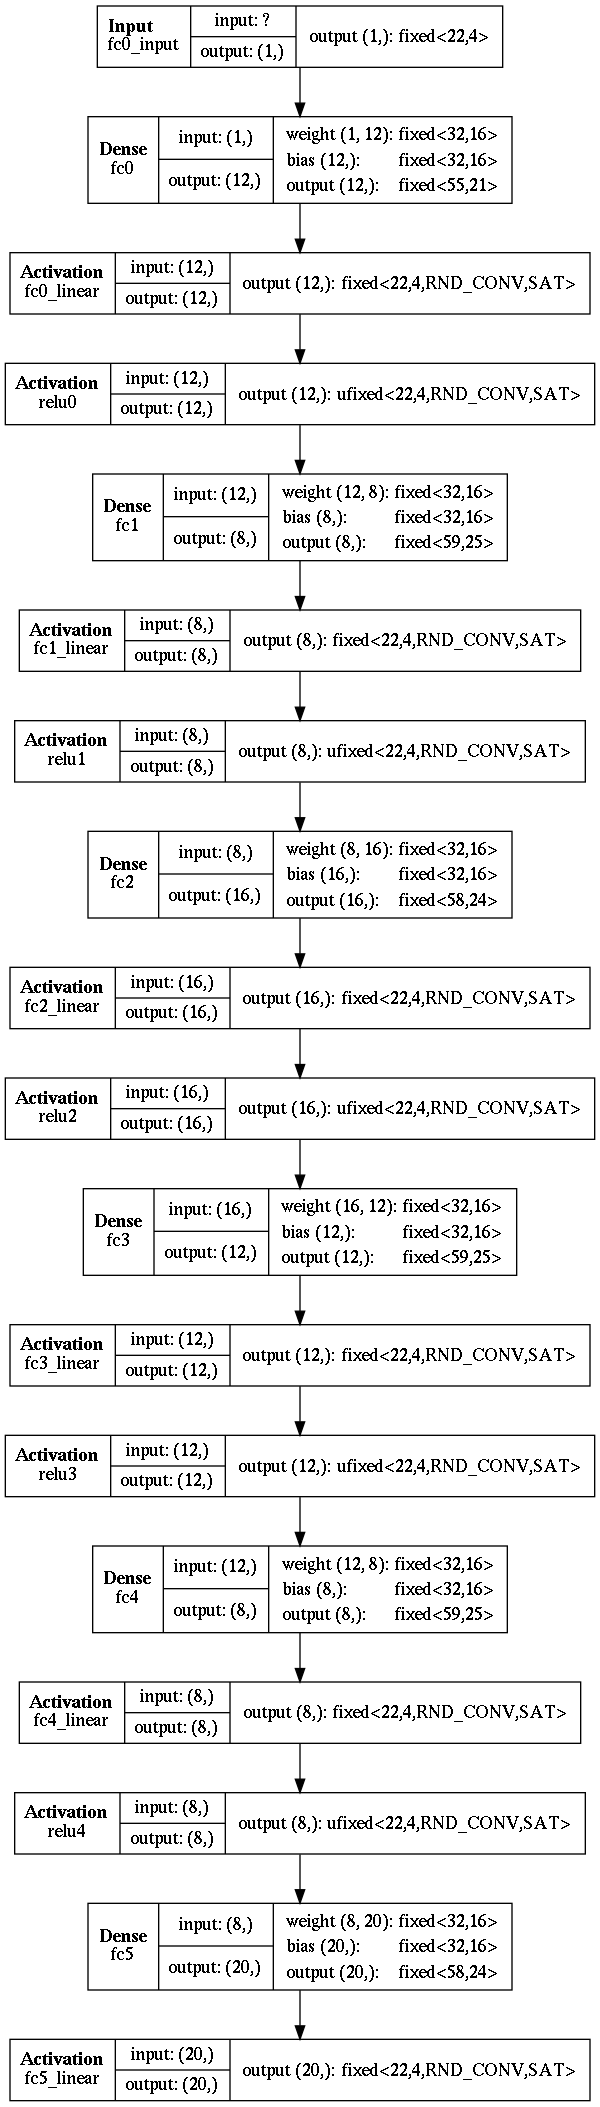

In [21]:
hls4ml.utils.plot_model(hmodel, show_shapes=True, show_precision=True, to_file=None)

In [22]:
hmodel.compile()

Writing HLS project
Done


##### Tracing and debugging

In [23]:
# Run tracing on the test set for the hls4ml model (fixed-point precision) 
hls4ml_pred, hls4ml_trace = hmodel.trace(np.ascontiguousarray(np.array(x_test).reshape((len(x_test), 1))))#, write_project=True)

Recompiling myproject with tracing
Writing HLS project
Done


In [24]:
# Run tracing on a portion of the test set for the Keras model (floating-point precision)
keras_trace = hls4ml.model.profiling.get_ymodel_keras(qmodel, x_test)

Processing fc0 in Keras model...
Processing relu0 in Keras model...
Processing fc1 in Keras model...
Processing relu1 in Keras model...
Processing fc2 in Keras model...
Processing relu2 in Keras model...
Processing fc3 in Keras model...
Processing relu3 in Keras model...
Processing fc4 in Keras model...
Processing relu4 in Keras model...
Processing fc5 in Keras model...
Done taking outputs for Keras model.


You can visualize traces of the hls4ml model and compare them with Keras and QKeras models.

In [25]:
layer_name='fc3'

In [26]:
print(hls4ml_trace[layer_name][0])

[ 0.02931043 -0.01428915 -0.14268695  0.10297995 -0.06252324  0.03816233
  0.07031003 -0.11329945 -0.07291447 -0.04891147  0.0476039   0.03137746]


In [27]:
print(hls4ml_trace[layer_name][1000][10])

0.05267771752551198


In [28]:
print(keras_trace[layer_name][1000][10])

0.052706756


In [29]:
print(keras_trace[layer_name][0])

[ 0.02931306 -0.01425174 -0.142687    0.1030013  -0.06248664  0.03815716
  0.07033265 -0.11329079 -0.07291411 -0.04890828  0.04763388  0.03138862]


Compare the traces of the QKeras and hls4ml models. When converting a model from QKeras to hls4ml, the precision of the weights and biases is **automatically** imported. Instead, the designer has to **manually tune** the precision of the accumulators and outputs for each layer. See the previous section [Convert model](#Convert-model).

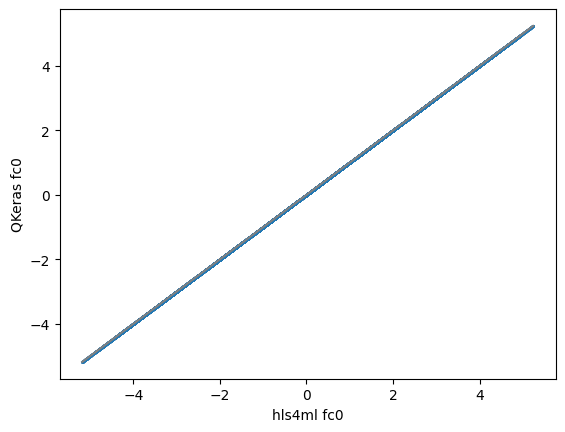

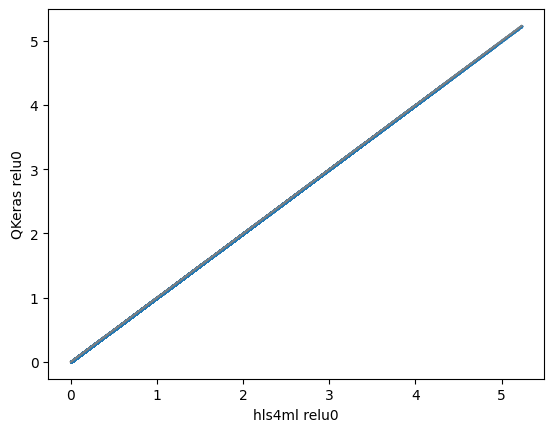

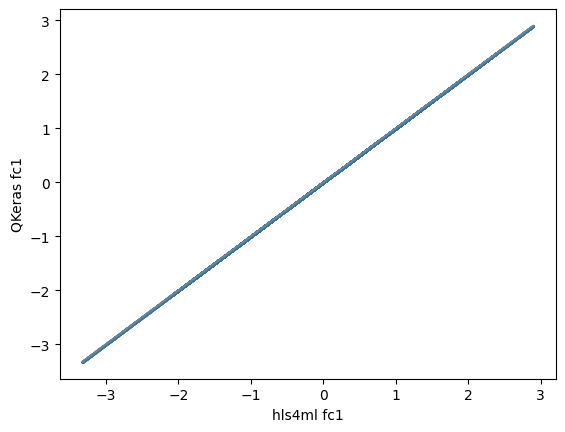

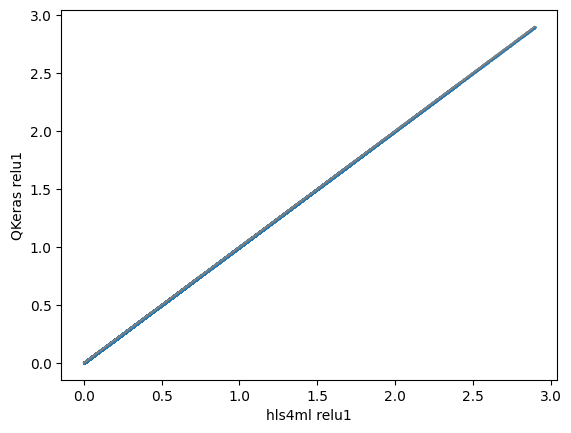

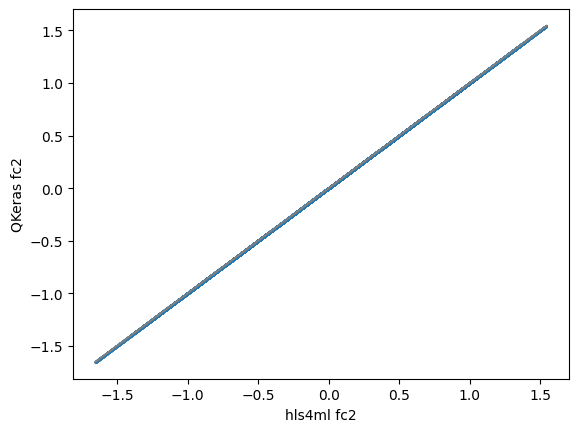

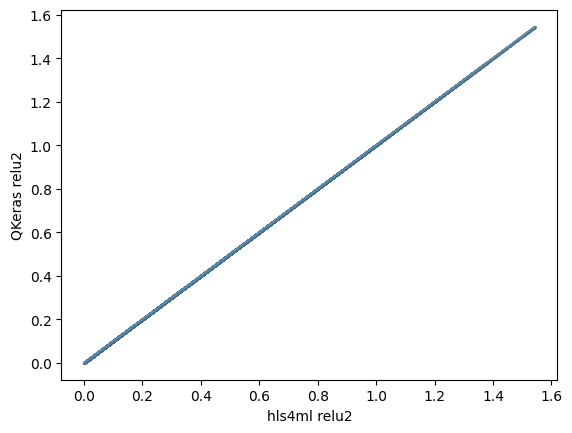

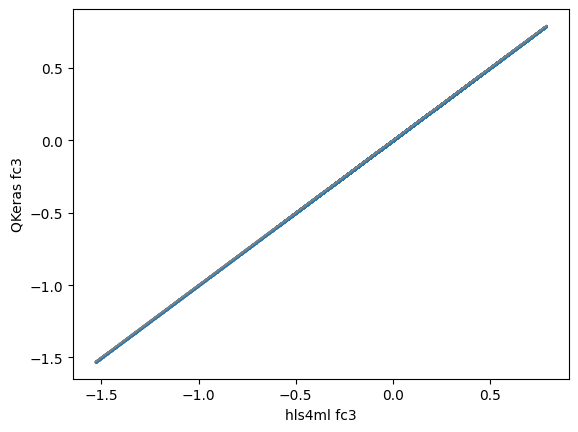

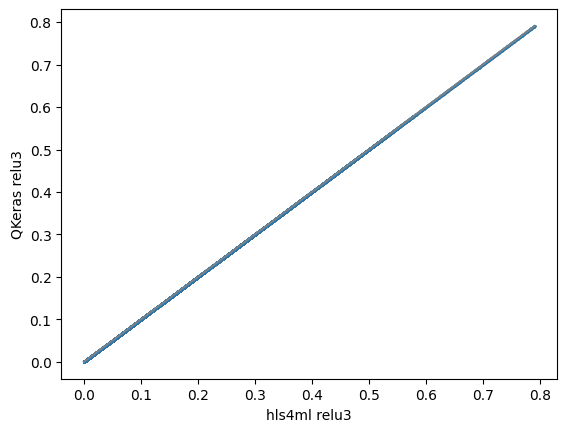

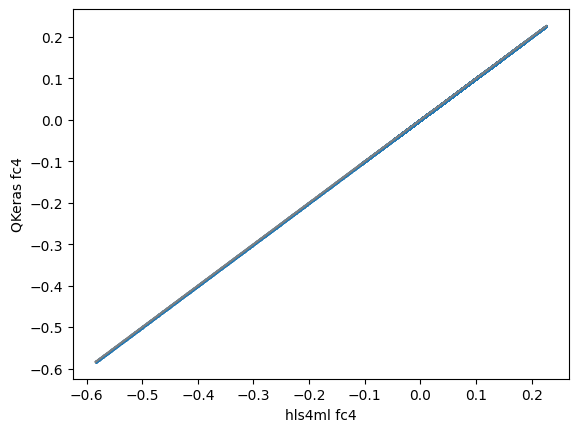

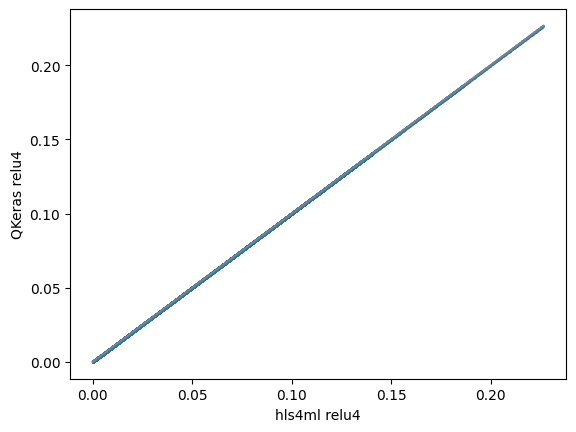

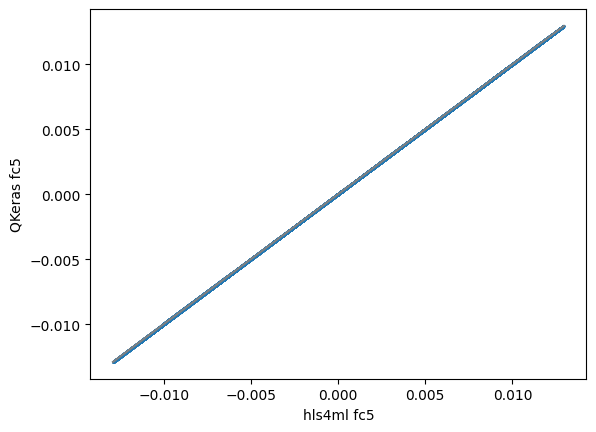

In [30]:
for layer in hls4ml_trace.keys():
    if '_linear' in layer:
        continue
        #klayer = layer.replace('_linear', '')
    plt.figure()
    klayer = layer
    plt.scatter(hls4ml_trace[layer].flatten(), keras_trace[klayer].flatten(), s=0.2)
    min_x = min(np.amin(hls4ml_trace[layer]), np.amin(keras_trace[klayer]))
    max_x = max(np.amax(hls4ml_trace[layer]), np.amax(keras_trace[klayer]))
    plt.plot([min_x, max_x], [min_x, max_x], c='gray')
    plt.xlabel('hls4ml {}'.format(layer))
    plt.ylabel('QKeras {}'.format(klayer))
    #plt.savefig(os.path.join(hmodel_prefix + '_' + str(run_id) + '_vivado_prj', 'profiling_{}.png'.format(layer)), dpi=300)

### Evaluation

In [31]:
from utils.metrics import hls4ml_evaluate

In [32]:
def eval_local_mse(a, b):
    assert(len(a)==len(b))
    M=len(a)
    accum = 0
    for i in range(len(a)):
        accum += (a[i]-b[i])**2
    return accum/len(a)

def hls4ml_evaluate(model, x_test, Y_test):
    import numpy as np
    assert(len(x_test)==len(Y_test))
    N=len(x_test)
    accum = 0
    for i in range(N):
        expected = Y_test[i:i+1][0]
        predicted = model.predict(np.ascontiguousarray(x_test[i]))
        accum += eval_local_mse(expected, predicted)
    return accum / len(x_test)

In [33]:
hmse = hls4ml_evaluate(hmodel, x_test, y_test)

In [34]:
y_hls4ml = hmodel.predict(np.ascontiguousarray(np.array(x_test).reshape((len(x_test), 1))))

In [35]:
import random
hash_id = random.getrandbits(32)
    
if FIDELITY_ENABLED:
    ygate_fidelity_hls4ml = get_ygate_fidelity(x_test,
                                               y_hls4ml,
                                               config_template=CONFIG_TEMPLATE_JSON,
                                               pulse_data_path='/tmp/ygate_{:x}.csv'.format(hash_id),
                                               output_objf_path='/tmp/ygate_fidelity_{:x}.csv'.format(hash_id))
else:
    ygate_fidelity_hls4ml = None

In [36]:
with pd.option_context('display.float_format', '{:0.12f}'.format):
    data = pd.DataFrame([["hls4ml", hmse, "", "", ygate_fidelity_hls4ml]], columns=["", "MSE", "MSLE", "MAPE", "Fidelity"])
    display(data)

,,MSE,MSLE,MAPE,Fidelity
0,hls4ml,0.000000117419,,,0.999976044998


Save metrics values to file for future reference.

In [37]:
metrics_filename = PREFIX + '/metrics.csv'

# You can disable the writing if necessary.
write_metrics_csv = True

In [39]:
from utils.metrics import write_metrics
if write_metrics_csv:
    write_metrics(metrics_filename, 'hls4ml', model_id, hmse, "", "", ygate_fidelity_hls4ml)

In [40]:
from utils.metrics import print_metrics
print_metrics(metrics_filename)

,Date,Framework,ID,MSE,MSLE,MAPE,Fidelity
0,04/06/2023 23:32:36,Keras,smallMLP_1x12x8x16x12x8x20,0.000000707116,NaN,NaN,0.990096302650
1,04/06/2023 23:41:26,Keras,smallMLP_1x16x16x16x16x16x16x16x20,0.000000302866,NaN,NaN,0.996592127711
2,05/06/2023 00:54:06,Keras,smallMLP_1x16x16x16x16x16x16x16x20,0.000000398108,NaN,NaN,0.995077184167
3,05/06/2023 01:35:19,Keras,smallMLP_1x16x16x16x16x16x16x16x20,0.000000326932,NaN,NaN,0.995693778354
4,05/06/2023 17:02:19,Keras,smallMLP_1x16x16x16x16x16x16x16x20,0.000003161936,NaN,NaN,0.978272227910
5,05/06/2023 17:41:50,Keras,smallMLP_1x16x16x16x16x16x16x16x20,0.000000187962,NaN,NaN,0.999987138670
6,05/06/2023 22:18:00,QKeras,smallMLP_1x16x16x16x16x16x16x16x20,0.001994839637,NaN,NaN,0.360618878665
7,05/06/2023 22:26:55,Keras,smallMLP_1x12x8x16x12x8x20,0.000000192853,NaN,NaN,0.999983054298
8,05/06/2023 22:29:33,QKeras,smallMLP_1x12x8x16x12x8x20,0.078390441835,NaN,NaN,0.252139220410
9,05/06/2023 23:26:05,QKeras,smallMLP_1x12x8x16x12x8x20,0.000000138960,NaN,NaN,0.999987939607


### Comparison

In [41]:
y_keras = model.predict(x_test)
y_qkeras = qmodel.predict(x_test)
y_hls4ml = hmodel.predict(np.ascontiguousarray(np.array(x_test).reshape((len(x_test), 1))))

In [42]:
data_y_test = pd.DataFrame(y_test)
data_y_test = data_y_test.reset_index(drop=True)

data_x_test = pd.DataFrame(x_test)
data_x_test = data_x_test.reset_index(drop=True)

data_test = pd.concat([data_y_test, data_x_test], axis=1)
display(data_test)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,0
0,0.000007,0.000016,0.000021,-0.000028,0.000016,0.000011,-0.000055,0.000004,0.000009,0.000062,...,0.002790,0.002438,0.002406,0.002505,0.002541,0.002541,0.002517,0.002743,0.003877,-0.651536
1,0.000014,0.000033,0.000047,-0.000055,0.000026,0.000017,-0.000110,0.000025,0.000055,0.000137,...,-0.010897,-0.011381,-0.011407,-0.011329,-0.011301,-0.011301,-0.011319,-0.010890,-0.008923,2.787041
2,0.000016,0.000040,0.000059,-0.000058,0.000037,0.000024,-0.000125,0.000027,0.000057,0.000156,...,0.010260,0.010226,0.010189,0.010302,0.010343,0.010344,0.010316,0.010154,0.010048,-2.564678
3,-0.000003,-0.000025,-0.000014,-0.000043,0.000013,0.000022,-0.000029,0.000032,0.000036,0.000063,...,-0.000686,-0.000002,-0.000033,0.000063,0.000097,0.000098,0.000074,-0.000685,-0.003168,0.059777
4,0.000009,0.000017,0.000031,-0.000049,0.000026,0.000020,-0.000089,0.000016,0.000030,0.000110,...,-0.006228,-0.006108,-0.006143,-0.006037,-0.005999,-0.005999,-0.006024,-0.006210,-0.006806,1.530087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16379,0.000011,0.000023,0.000041,-0.000056,0.000033,0.000025,-0.000107,0.000023,0.000043,0.000136,...,-0.008161,-0.008101,-0.008138,-0.008027,-0.007987,-0.007987,-0.008014,-0.008149,-0.008449,2.021488
16380,-0.000002,-0.000021,-0.000011,-0.000044,0.000012,0.000020,-0.000033,0.000032,0.000038,0.000066,...,-0.001478,-0.000923,-0.000955,-0.000856,-0.000821,-0.000820,-0.000844,-0.001477,-0.003467,0.276569
16381,0.000016,0.000044,0.000060,-0.000047,0.000036,0.000026,-0.000105,0.000038,0.000069,0.000144,...,0.011675,0.012083,0.012057,0.012137,0.012165,0.012166,0.012146,0.011539,0.009516,-2.976594
16382,0.000009,0.000013,0.000030,-0.000058,0.000027,0.000024,-0.000095,0.000031,0.000052,0.000128,...,-0.008591,-0.008779,-0.008810,-0.008716,-0.008682,-0.008682,-0.008704,-0.008584,-0.007927,2.166975


In [43]:
data_y_keras = pd.DataFrame(y_keras)
data_y_keras = data_y_keras.reset_index(drop=True)

data_x_test = pd.DataFrame(x_test)
data_x_test = data_x_test.reset_index(drop=True)

data_keras = pd.concat([data_y_keras, data_x_test], axis=1)
display(data_keras)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,0
0,0.000007,0.000017,0.000015,-0.000056,-4.196772e-07,-0.000045,-0.000016,0.000043,1.269450e-05,5.836342e-05,...,0.002767,0.002387,0.002381,0.002494,0.002545,0.002455,0.002440,0.002567,0.003549,-0.651536
1,-0.000083,0.000009,-0.000082,-0.000173,-4.131743e-05,-0.000045,-0.000016,0.000081,-4.417858e-05,7.189339e-05,...,-0.010985,-0.011352,-0.011354,-0.011331,-0.011214,-0.011281,-0.011255,-0.010845,-0.009162,2.787041
2,0.000014,0.000035,0.000020,-0.000036,2.417411e-05,0.000007,-0.000072,0.000025,2.096244e-05,1.031428e-04,...,0.010346,0.010275,0.010242,0.010336,0.010381,0.010358,0.010336,0.010023,0.009360,-2.564678
3,-0.000064,-0.000044,0.000193,-0.000027,-1.562233e-04,0.000023,-0.000012,0.000013,2.064078e-06,2.930174e-07,...,-0.000133,-0.000253,-0.000230,-0.000208,-0.000155,-0.000200,-0.000071,-0.000655,-0.001142,0.059777
4,-0.000063,0.000015,-0.000025,-0.000146,2.553617e-05,0.000022,-0.000067,0.000017,-2.532555e-05,6.470509e-05,...,-0.006128,-0.006132,-0.006166,-0.006115,-0.006046,-0.005982,-0.005970,-0.006011,-0.006328,1.530087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16379,-0.000059,0.000022,-0.000004,-0.000085,-6.866991e-05,0.000041,-0.000099,0.000055,-1.032964e-05,1.443089e-04,...,-0.007854,-0.008205,-0.008237,-0.008256,-0.008158,-0.008162,-0.008115,-0.008065,-0.007184,2.021488
16380,-0.000088,-0.000057,0.000154,-0.000054,-1.677915e-04,0.000039,-0.000018,0.000030,-6.563043e-07,2.923544e-05,...,-0.001404,-0.000957,-0.000944,-0.000952,-0.000884,-0.000911,-0.000780,-0.001651,-0.003588,0.276569
16381,0.000049,0.000036,0.000069,0.000029,2.362195e-05,0.000040,-0.000104,0.000020,7.177133e-05,1.149354e-04,...,0.011696,0.012128,0.012086,0.012190,0.012212,0.012208,0.012203,0.011442,0.008948,-2.976594
16382,-0.000053,0.000017,0.000007,-0.000081,-6.548990e-05,0.000033,-0.000086,0.000050,-8.349140e-06,1.303784e-04,...,-0.008420,-0.008844,-0.008871,-0.008876,-0.008786,-0.008798,-0.008755,-0.008639,-0.007510,2.166975


In [44]:
data_y_qkeras = pd.DataFrame(y_qkeras)
data_y_qkeras = data_y_qkeras.reset_index(drop=True)

data_x_test = pd.DataFrame(x_test)
data_x_test = data_x_test.reset_index(drop=True)

data_qkeras = pd.concat([data_y_qkeras, data_x_test], axis=1)
display(data_qkeras)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,0
0,0.000039,0.000041,-0.000013,-0.000032,0.000059,-0.000019,-0.000059,-0.000009,0.000028,0.000068,...,0.002751,0.002456,0.002419,0.002556,0.002589,0.002553,0.002500,0.002658,0.003551,-0.651536
1,0.000089,0.000093,0.000036,0.000001,0.000080,-0.000004,-0.000156,0.000028,0.000131,0.000125,...,-0.011018,-0.011393,-0.011423,-0.011293,-0.011254,-0.011309,-0.011309,-0.010825,-0.009065,2.787041
2,0.000012,0.000027,0.000089,-0.000032,0.000004,0.000030,-0.000101,-0.000008,0.000055,0.000140,...,0.010416,0.010306,0.010270,0.010348,0.010375,0.010373,0.010348,0.009942,0.009695,-2.564678
3,-0.000041,-0.000047,-0.000039,-0.000117,0.000012,0.000008,0.000017,0.000002,0.000003,0.000078,...,-0.000729,-0.000017,-0.000057,0.000033,0.000065,0.000075,0.000010,-0.000792,-0.003391,0.059777
4,0.000036,0.000047,0.000030,0.000012,0.000017,0.000055,-0.000142,-0.000002,0.000070,0.000099,...,-0.006257,-0.006117,-0.006166,-0.006096,-0.006050,-0.006034,-0.006003,-0.006162,-0.006528,1.530087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16379,0.000057,0.000065,0.000033,0.000008,0.000042,0.000032,-0.000148,0.000010,0.000094,0.000109,...,-0.008119,-0.008179,-0.008221,-0.008128,-0.008085,-0.008096,-0.008078,-0.007985,-0.007520,2.021488
16380,0.000029,0.000003,-0.000037,-0.000049,0.000055,-0.000029,-0.000014,0.000020,0.000059,0.000041,...,-0.001513,-0.000963,-0.000987,-0.000846,-0.000812,-0.000859,-0.000901,-0.001486,-0.003657,0.276569
16381,0.000033,0.000071,0.000029,-0.000056,0.000069,-0.000001,-0.000114,0.000027,0.000088,0.000096,...,0.011660,0.012094,0.012074,0.012177,0.012229,0.012211,0.012220,0.011375,0.009089,-2.976594
16382,0.000063,0.000070,0.000033,0.000007,0.000049,0.000025,-0.000149,0.000013,0.000101,0.000112,...,-0.008670,-0.008790,-0.008830,-0.008729,-0.008687,-0.008707,-0.008692,-0.008524,-0.007814,2.166975


In [45]:
data_y_hls4ml = pd.DataFrame(y_hls4ml)
data_y_hls4ml = data_y_hls4ml.reset_index(drop=True)

data_x_test = pd.DataFrame(x_test)
data_x_test = data_x_test.reset_index(drop=True)

data_hls4ml = pd.concat([data_y_hls4ml, data_x_test], axis=1)
display(data_hls4ml)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,0
0,0.000031,0.000027,-0.000019,-0.000046,0.000046,-0.000031,-0.000069,-0.000023,0.000008,0.000065,...,0.002754,0.002457,0.002411,0.002548,0.002575,0.002556,0.002487,0.002644,0.003536,-0.651536
1,0.000084,0.000076,0.000031,-0.000008,0.000065,-0.000019,-0.000175,0.000011,0.000111,0.000122,...,-0.011009,-0.011372,-0.011414,-0.011280,-0.011246,-0.011288,-0.011307,-0.010830,-0.009102,2.787041
2,0.000008,0.000008,0.000092,-0.000034,-0.000011,0.000023,-0.000111,-0.000019,0.000042,0.000145,...,0.010426,0.010315,0.010269,0.010349,0.010368,0.010380,0.010334,0.009918,0.009666,-2.564678
3,-0.000046,-0.000057,-0.000046,-0.000130,0.000004,-0.000008,0.000004,-0.000008,-0.000015,0.000072,...,-0.000729,-0.000019,-0.000069,0.000027,0.000053,0.000080,0.000000,-0.000797,-0.003407,0.059777
4,0.000031,0.000034,0.000027,0.000004,0.000008,0.000038,-0.000156,-0.000015,0.000053,0.000095,...,-0.006248,-0.006107,-0.006165,-0.006088,-0.006050,-0.006020,-0.006004,-0.006165,-0.006554,1.530087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16379,0.000053,0.000050,0.000027,-0.000004,0.000031,0.000015,-0.000164,-0.000004,0.000076,0.000107,...,-0.008110,-0.008163,-0.008217,-0.008118,-0.008083,-0.008080,-0.008080,-0.007988,-0.007549,2.021488
16380,0.000023,-0.000008,-0.000042,-0.000061,0.000046,-0.000046,-0.000027,0.000008,0.000042,0.000034,...,-0.001511,-0.000965,-0.000996,-0.000851,-0.000820,-0.000854,-0.000912,-0.001492,-0.003674,0.276569
16381,0.000027,0.000053,0.000031,-0.000065,0.000053,-0.000008,-0.000126,0.000015,0.000069,0.000103,...,0.011665,0.012104,0.012074,0.012173,0.012218,0.012218,0.012207,0.011349,0.009060,-2.976594
16382,0.000061,0.000057,0.000027,-0.000004,0.000038,0.000008,-0.000168,0.000000,0.000084,0.000111,...,-0.008659,-0.008774,-0.008823,-0.008720,-0.008682,-0.008690,-0.008694,-0.008530,-0.007843,2.166975


In [46]:
data_keras.to_csv('keras_results.csv')
data_qkeras.to_csv('qkeras_results.csv')
data_hls4ml.to_csv('hls4ml_results.csv')

In [47]:
data_test.to_csv('reference.csv')

### Parameters

Plot and compare the Keras, QKeras, and hls4ml predictions with the reference in the dataset.

In [48]:
print('Expected number of plots (test set size):', y_test.shape[0])

Expected number of plots (test set size): 16384


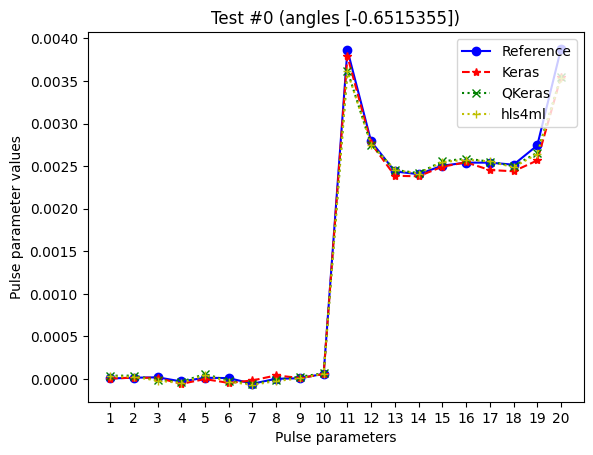

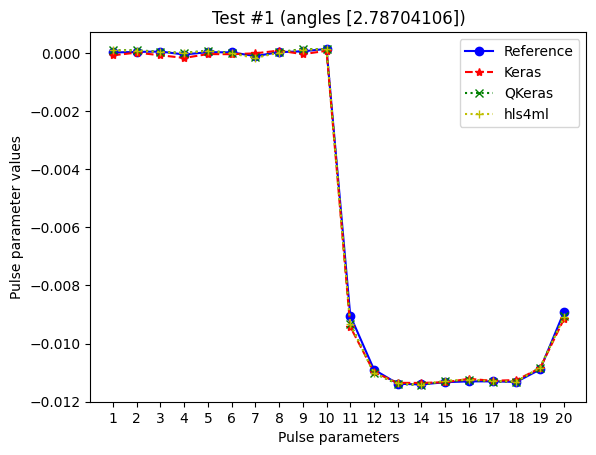

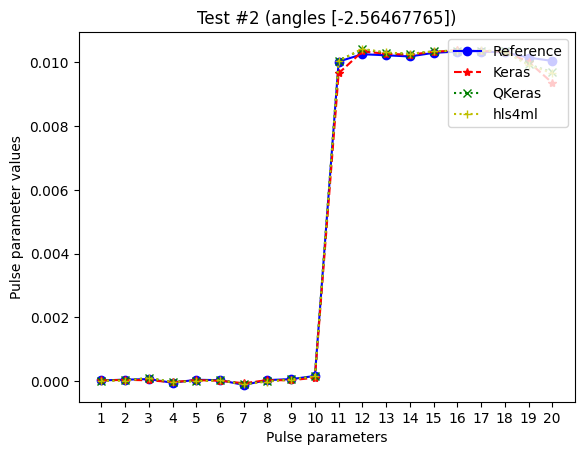

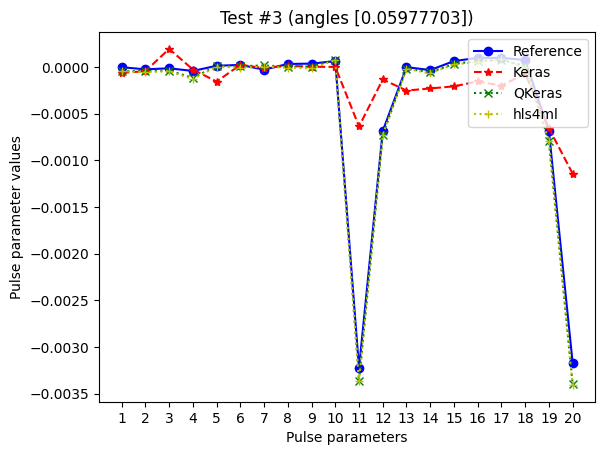

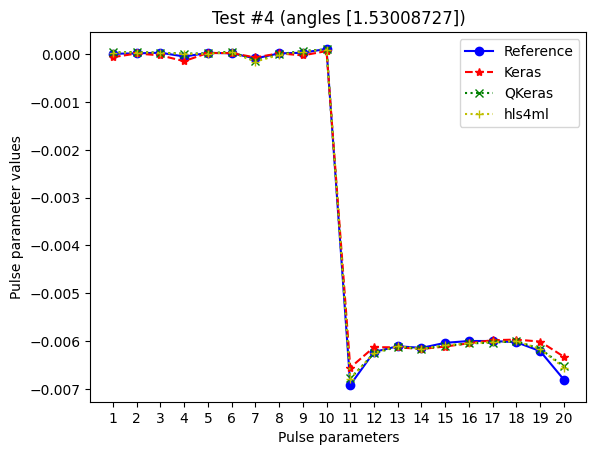

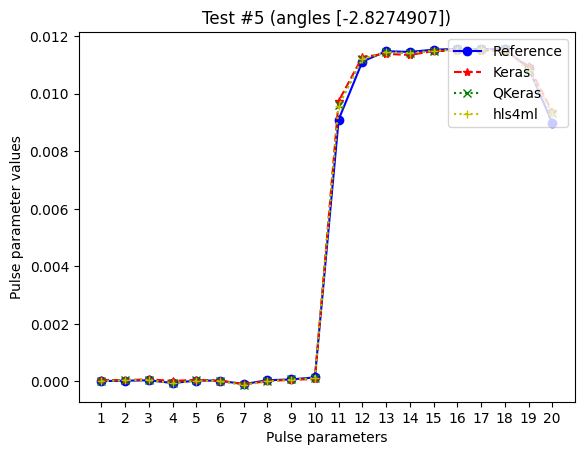

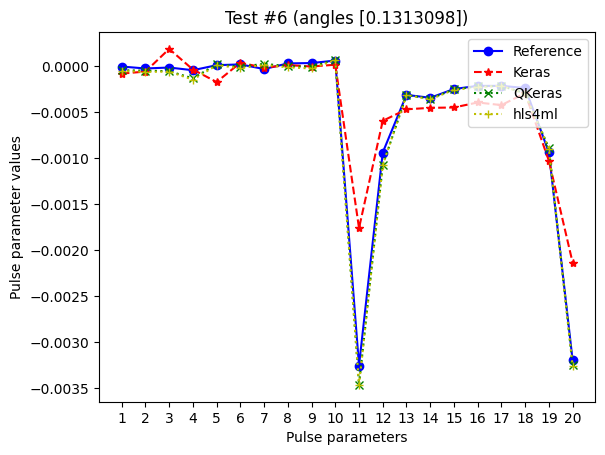

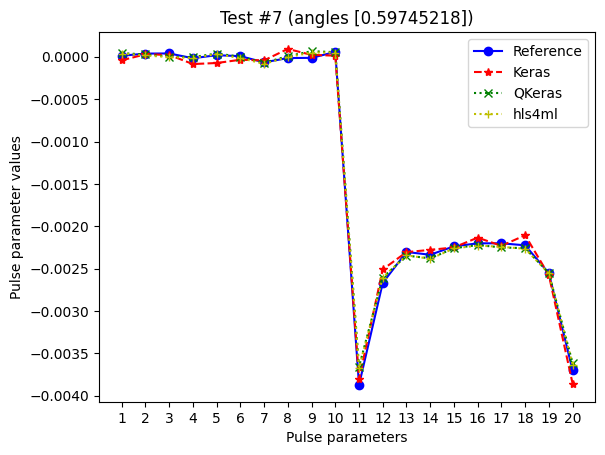

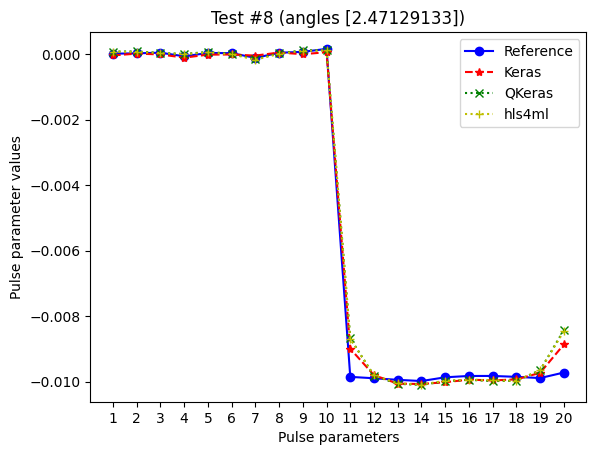

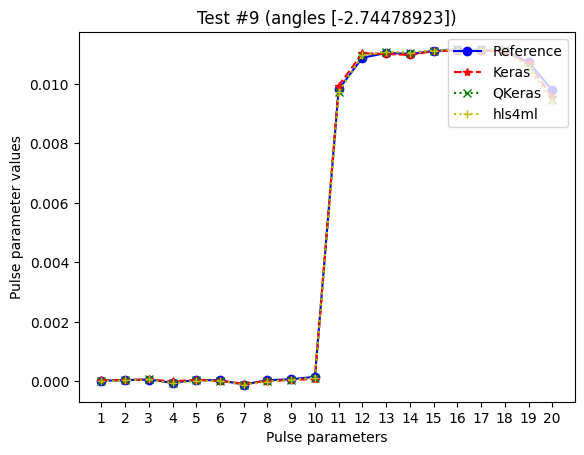

In [49]:
x = np.arange(1, y_test.shape[1]+1, 1)
for i in range(10):#Y_test.shape[0]):
    plt.clf()
    #plt.rcParams["figure.figsize"] = (10,5)
    plt.plot(x, y_test[i], marker='o', linestyle='-', color='b') 
    plt.plot(x, y_keras[i], marker='*', linestyle='--', color='r')
    plt.plot(x, y_qkeras[i], marker='x', linestyle=':', color='g')
    plt.plot(x, y_hls4ml[i], marker='+', linestyle=':', color='y')
    plt.xticks(x, x)
    plt.legend(['Reference', 'Keras', 'QKeras','hls4ml'], loc='upper right')
    plt.ylabel('Pulse parameter values')
    plt.xlabel('Pulse parameters')
    plt.title('Test #{} (angles {})'.format(i, x_test[i]))
    #plt.ylim([min_pparam_value, max_pparam_value])
    plt.show()

### Pulse

In [50]:
if PULSE_ENABLED:
    plot_ygate_pulse(x_test.values[0], y_test.to_numpy()[0], verbose=False)

In [51]:
if PULSE_ENABLED:
    plot_ygate_pulse(x_test.values[0], y_keras[0], verbose=False)

In [52]:
if PULSE_ENABLED:
    plot_ygate_pulse(x_test.values[0], y_qkeras[0], verbose=False)

In [53]:
if PULSE_ENABLED:
    plot_ygate_pulse(x_test.values[0], y_hls4ml[0], verbose=False)